In [1]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
base_dir = '/home/iplab/Desktop/Shaker/Brain tumor MRI and CT scan/data(processed)'

In [4]:
# read mr and ct datasets
MR_train_address = os.path.join(base_dir, 'train_input.npy')
CT_train_address = os.path.join(base_dir, 'train_output.npy')

MR_val_address = os.path.join(base_dir, 'val_input.npy')
CT_val_address = os.path.join(base_dir, 'val_output.npy')

MR_test_address = os.path.join(base_dir, 'test_input.npy')
CT_test_address = os.path.join(base_dir, 'test_output.npy')

mr_train = np.load(MR_train_address)
ct_train = np.load(CT_train_address)

mr_val = np.load(MR_val_address)
ct_val = np.load(CT_val_address)

mr_test = np.load(MR_test_address)
ct_test = np.load(CT_test_address)

In [5]:
ct_train.shape, ct_val.shape, ct_test.shape

((570, 256, 256), (90, 256, 256), (150, 256, 256))

In [6]:
def convert_to_3channel(img):
  img = img.astype('float32')
  img_3channel = np.dstack((img, img, img))
  return img_3channel

In [7]:
# convert 1 channel mr and ct images to 3 channel for later processing
n_train_samples = ct_train.shape[0]
n_val_samples = ct_val.shape[0]
n_test_samples = ct_test.shape[0]

n_total_samples = n_train_samples + n_val_samples + n_test_samples

mr_total = [None] * n_total_samples
ct_total = [None] * n_total_samples


for i in range(n_train_samples):

  mr_total[i] = convert_to_3channel(mr_train[i])
  ct_total[i] = convert_to_3channel(ct_train[i])


for i in range(n_val_samples):

  j = i + n_train_samples

  mr_total[j] = convert_to_3channel(mr_val[i])
  ct_total[j] = convert_to_3channel(ct_val[i])


for i in range(n_test_samples):

  j = i + n_train_samples + n_val_samples

  mr_total[j] = convert_to_3channel(mr_test[i])
  ct_total[j] = convert_to_3channel(ct_test[i])


# convert lists of mr and ct to tensors
mr_total = np.array(mr_total)
mr_total = torch.tensor(mr_total)

ct_total = np.array(ct_total)
ct_total = torch.tensor(ct_total)

print('mr images shape:', mr_total[0].shape)
print('ct images shape:', ct_total[0].shape)

mr images shape: torch.Size([256, 256, 3])
ct images shape: torch.Size([256, 256, 3])


In [8]:
dataset = TensorDataset(mr_total, ct_total)
dataloader = DataLoader(dataset, batch_size=1, num_workers=2)

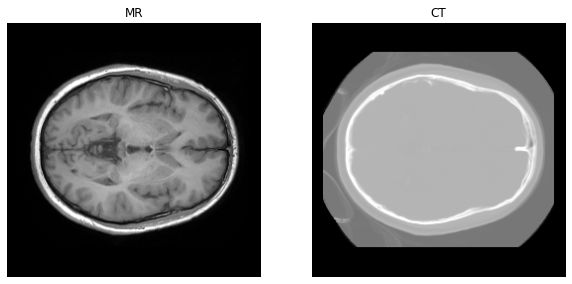

In [9]:
# show samples of dataset
n_samples_to_show = 1
rows = 1
columns = 2

for i, pair in enumerate(dataloader):

  mr = pair[0].squeeze()
  ct = pair[1].squeeze()

  fig = plt.figure(figsize=(10, 10))

  fig.add_subplot(rows, columns, 1)
  plt.imshow(mr)
  plt.axis('off')
  plt.title('MR')

  fig.add_subplot(rows, columns, 2)
  plt.imshow(ct)
  plt.axis('off')
  plt.title('CT')

  plt.show()

  if i == n_samples_to_show-1:
    break

In [10]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [11]:
def show_diffusion_forward(img):

  plt.figure(figsize=(40,40))
  plt.axis('off')

  num_images = 10
  stepsize = int(T/num_images)

  for idx in range(0, T, stepsize):

      plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
      t = torch.Tensor([idx]).type(torch.int64)

      noisy_sample, noise = forward_diffusion_sample(img, t)
      plt.imshow(noisy_sample)

<ipython-input-11-9a28144a7088>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

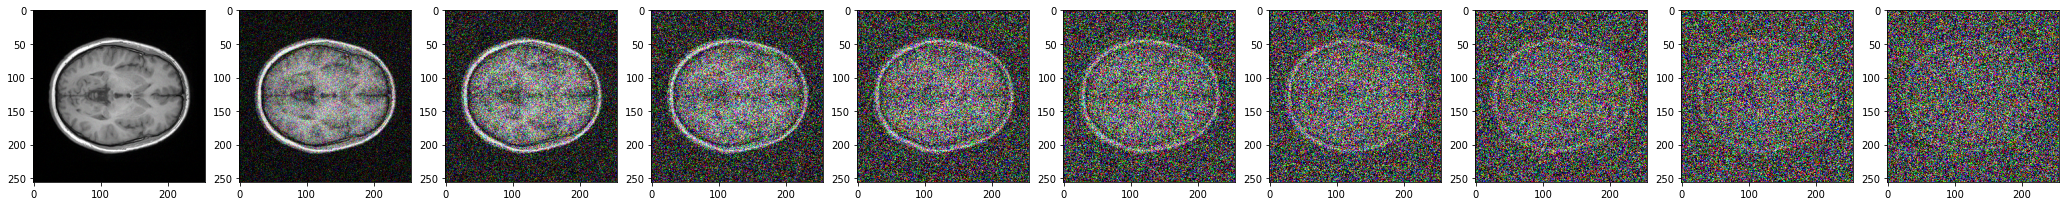

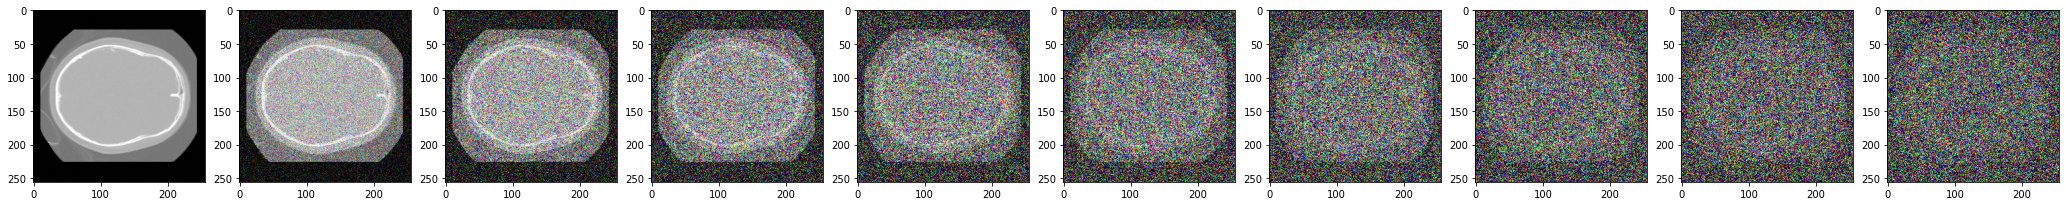

In [12]:
# show the forward process of diffusion for one pair of MR and CT
n_samples_to_show = 1

for i, pair in enumerate(dataloader):

  mr = pair[0].squeeze()
  ct = pair[1].squeeze()

  show_diffusion_forward(mr)
  show_diffusion_forward(ct)

  if i == n_samples_to_show-1:
    break

In [13]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        # down_channels = (64, 128, 256, 512, 1024)
        # up_channels = (1024, 512, 256, 128, 64)
        down_channels = (256, 256, 256, 512, 1024)
        up_channels = (1024, 512, 256, 256, 265)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  69048463


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transf

In [14]:
# returns the real noise and the predicted noise added to an image
def get_real_pred_noise(model, img, t):

    x_noisy, noise = forward_diffusion_sample(img, t, device)

    x_noisy = x_noisy.permute(0, 3, 1, 2)
    noise = noise.permute(0, 3, 1, 2)

    noise_pred = model(x_noisy, t)
    
    return (noise, noise_pred)
    # return F.l1_loss(noise, noise_pred)

In [15]:
epochs = 1
stop_idx = 600
step_size = 100

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
  for i, pair in enumerate(dataloader):

    mr = pair[0]
    ct = pair[1]

    optimizer.zero_grad()

    t_last = torch.tensor([T-1], device=device)

    noise_mr_t, noise_pred_mr_t = get_real_pred_noise(model, mr, t_last)
    noise_ct_t, noise_pred_ct_t = get_real_pred_noise(model, ct, t_last)

    noise_difference = noise_mr_t - noise_ct_t
    noise_pred_difference = noise_pred_mr_t - noise_pred_ct_t

    loss = F.l1_loss(noise_difference, noise_pred_difference)

    loss.backward()
    optimizer.step()

    
    print(f'sample {i}:')

    for t in range(1,T)[::-1]:

      optimizer.zero_grad()

      t = torch.tensor([t], device=device)
      noise_t, noise_pred_t = get_real_pred_noise(model, ct, t)
      noise_t_minus_one, noise_pred_t_minus_one = get_real_pred_noise(model, ct, t-1)

      noise_difference = noise_t - noise_t_minus_one
      noise_pred_difference = noise_pred_t - noise_pred_t_minus_one

      loss = F.l1_loss(noise_difference, noise_pred_difference)

      loss.backward()
      optimizer.step()

      if t % step_size == 0:
        loss = round(loss.item(), 2)
        print('loss:', loss)

    if i == stop_idx-1:
      break

sample 0:
loss: 0.1
loss: 0.07
sample 1:
loss: 0.05
loss: 0.05
sample 2:
loss: 0.04
loss: 0.05
sample 3:
loss: 0.04
loss: 0.04
sample 4:
loss: 0.09
loss: 0.08
sample 5:
loss: 0.08
loss: 0.19
sample 6:
loss: 0.07
loss: 0.12
sample 7:
loss: 0.24
loss: 0.28
sample 8:
loss: 0.14
loss: 0.28
sample 9:
loss: 0.09
loss: 0.14
sample 10:
loss: 0.13
loss: 0.12
sample 11:
loss: 0.13
loss: 0.1
sample 12:
loss: 0.13
loss: 0.15
sample 13:
loss: 0.08
loss: 0.1
sample 14:
loss: 0.1
loss: 0.13
sample 15:
loss: 0.09
loss: 0.1
sample 16:
loss: 0.09
loss: 0.09
sample 17:
loss: 0.08
loss: 0.09
sample 18:
loss: 0.09
loss: 0.14
sample 19:
loss: 0.07
loss: 0.15
sample 20:
loss: 0.06
loss: 0.13
sample 21:
loss: 0.05
loss: 0.12
sample 22:
loss: 0.07
loss: 0.11
sample 23:
loss: 0.05
loss: 0.08
sample 24:
loss: 0.08
loss: 0.07
sample 25:
loss: 0.1
loss: 0.08
sample 26:
loss: 0.09
loss: 0.11
sample 27:
loss: 0.09
loss: 0.13
sample 28:
loss: 0.07
loss: 0.08
sample 29:
loss: 0.05
loss: 0.08
sample 30:
loss: 0.05
loss

KeyboardInterrupt: 

In [ ]:
save_path = os.path.join(base_dir, f'model_{T}_epoch_{epochs}_samples_{stop_idx}.pt')
torch.save(model.state_dict(), save_path)

In [ ]:
# plot the output of the model
def reshape_tensor_to_plot(tensor):

  tensor = tensor.squeeze()
  tensor = tensor.detach().cpu().numpy()

  dim1 = tensor.shape[0]
  dim2 = tensor.shape[1]
  dim3 = tensor.shape[2]

  tensor = np.reshape(tensor, (dim3, dim2, dim1))

  return tensor
  # plt.imshow(tensor)
  # plt.show()

In [ ]:
# change the dimonsion of the input image
# to be suitable for diffusion sampling (sample_plot_image function)
def prepare_for_diffusion_sample(img):

  dim1 = img.shape[0]
  dim2 = img.shape[1]
  dim3 = img.shape[2]

  reshaped_img = np.reshape(img, (dim3, dim2, dim1))
  reshaped_img = reshaped_img.unsqueeze(0)

  return reshaped_img

In [ ]:
diffusion_outputs_path = os.path.join(base_dir, f'diffusion_outputs_T_{T}_epoch_{epochs}_samples_{stop_idx}')
os.mkdir(diffusion_outputs_path)

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    denoised_img = x - model(x, t)

    return denoised_img
    # betas_t = get_index_from_list(betas, t, x.shape)
    # sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
    #     sqrt_one_minus_alphas_cumprod, t, x.shape
    # )
    # sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # # Call model (current image - noise prediction)
    # model_mean = sqrt_recip_alphas_t * (
    #     x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    # )
    # posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    # if t == 0:
    #     # As pointed out by Luis Pereira (see YouTube comment)
    #     # The t's are offset from the t's in the paper
    #     return model_mean
    # else:
    #     noise = torch.randn_like(x)
    #     return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_save_diff_out(img):
    # Sample noise
    img_size = 256
    # img = torch.randn((1, 3, img_size, img_size), device=device)
    # plt.figure(figsize=(15,15))
    # plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
    #     # Edit: This is to maintain the natural range of the distribution
    #     img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0 or i == 0:
          # print(img.shape)
          diff_out = reshape_tensor_to_plot(img)

          diff_out_file_name = f'diff_out_{i}'
          diff_out_file_path = os.path.join(diffusion_outputs_path, diff_out_file_name)

          np.save(diff_out_file_path, diff_out)
            # plt.subplot(1, num_images, int(i/stepsize)+1)
    #         show_tensor_image(img.detach().cpu())
    # plt.show()

In [ ]:
diffusion_step = T-1 
t = torch.full((1,), diffusion_step, device=device, dtype=torch.long)

mr_sample = mr_total[0]

noisy_mr, noise = forward_diffusion_sample(mr_sample, t)

noisy_mr = prepare_for_diffusion_sample(noisy_mr)
noisy_mr = noisy_mr.to(device)

In [ ]:
sample_save_diff_out(noisy_mr)

In [ ]:
diffusion_outputs_saved = os.listdir(diffusion_outputs_path)

for file_name in diffusion_outputs_saved:
  file_address = os.path.join(diffusion_outputs_path, file_name)
  diff_out = np.load(file_address)
  # print(diff_out.shape)
  plt.imshow(diff_out)
  plt.show()